In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GATv2Conv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            torch.cuda.empty_cache()

            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=1, gamma=1, dropout=0.5):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class SqMatrixLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.A = nn.Parameter(torch.randn((out_dim, in_dim), device=DEVICE))
        self.B = nn.Parameter(torch.randn((in_dim, out_dim), device=DEVICE))
        self.c = nn.Parameter(torch.randn((out_dim, 1), device=DEVICE))

    def forward(self, x):
        return self.A @ x @ self.B + self.c

class MainAdjStep(nn.Module):
    def __init__(self, old_dim, new_dim):
        super().__init__()
        self.layer1 = SqMatrixLayer(old_dim, old_dim)
        self.layer2 = SqMatrixLayer(old_dim, new_dim)
        self.layer3 = SqMatrixLayer(new_dim, new_dim)

        self.norm1 = nn.BatchNorm1d(old_dim)
        self.norm2 = nn.BatchNorm1d(new_dim)
        self.norm3 = nn.BatchNorm1d(new_dim)

    def forward(self, A):
        A = F.relu(self.norm1(self.layer1(A)))
        A = F.dropout(A, training=self.training)

        A = F.relu(self.norm2(self.layer2(A)))
        A = F.dropout(A, training=self.training)

        A = self.norm3(self.layer3(A))
        A = (A + torch.transpose(A, -1, -2)) / 2
        A = F.hardtanh(F.hardtanh(A, min_val=0), min_val=0)
        return A

        

In [8]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [9]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [10]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [17]:
def loss_calc(adj_ls, opp_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):
        total_loss = total_loss + mse_loss_fn(adj, opp_adj)
    
    total_loss = torch.sqrt(total_loss / len(adj_ls))

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def main_loss_calc(adj_ls, up_adj_ls, down_adj_ls, true_hr_adj, epoch, a=0.5, b=0.95, c=0.02):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = true_hr_adj[:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (main_adj, up_adj, down_adj) in enumerate(zip(adj_ls[:-1], up_adj_ls, down_adj_ls[::-1])):
        intermediate_mse_loss = intermediate_mse_loss + 0.5 * weights[i] * (mse_loss_fn(main_adj, down_adj) + mse_loss_fn(main_adj, up_adj))

    alpha = (1 - np.exp(-c * epoch)) * (a - b) + b 

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    return total_loss

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [45]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=32)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=8)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

super_resolver = [MainAdjStep(dim_steps[i], dim_steps[i+1]).to(DEVICE) for i in range(len(dim_steps)-1)]

up_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

all_super_resolver_params = []
for layer in super_resolver:
    all_super_resolver_params += list(layer.parameters())
super_resolver_optimizer = torch.optim.AdamW(all_super_resolver_params, lr=0.0025, betas=(0.5, 0.999))


sum(p.numel() for model in [up_changer, down_changer] + super_resolver for p in model.parameters())


6226168

In [58]:
def train(epochs, freeze_schedule, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, super_resolver_optimizer, ompleted_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'main': [], 'up_end_mae':[], 'up_reconst': [],'down_reconst':[], 'main_mae': []}

    up_changer.train()
    down_changer.train()   

    schedule = freeze_schedule.copy()
    freeze_epoch = schedule.pop(0)
    freeze_idx = 0
    
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        up_reconst_ls = []
        down_reconst_ls = []
        main_final_mae_ls = []
        down_losses = []
        main_losses = []
            


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)
        
            # optimise down to up direction
            down_optimizer.zero_grad()

            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])
            torch.cuda.empty_cache()

            down_loss = loss_calc(up_adj_ls, down_adj_ls)
        
            # for printing loss only
            down_reconst_ls.append(end_adj_loss_calc(adj_hr.to(DEVICE), up_adj_ls[-1].detach()))
            torch.cuda.empty_cache()
            
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()
        
            # optimise up to down direction
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), up_adj_ls[-1])
            torch.cuda.empty_cache()
        
            up_loss = loss_calc(down_adj_ls, up_adj_ls)

            # for printing loss only
            up_reconst_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), adj_lr.to(DEVICE)))
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), adj_hr.to(DEVICE)))
            torch.cuda.empty_cache()

            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()



            freeze_model(up_changer)
            freeze_model(down_changer)

            super_resolver_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), up_adj_ls[-1])
            torch.cuda.empty_cache()

            

            A = adj_lr.to(DEVICE)
            A_ls = []
            for layer in super_resolver:
                A = layer(A)
                torch.cuda.empty_cache()
                A_ls.append(A)
            
            main_loss = main_loss_calc(A_ls, up_adj_ls[1:-1], down_adj_ls[1:-1], adj_hr.to(DEVICE), epoch)
            
            # for printing loss only
            main_final_mae_ls.append(end_adj_loss_calc(A_ls[-1].detach(), adj_hr.to(DEVICE)))
            torch.cuda.empty_cache()

            main_loss.backward()
            super_resolver_optimizer.step()

            main_losses.append(main_loss.detach().item())
            del main_loss
            torch.cuda.empty_cache()

            if epoch == freeze_epoch:
                freeze_model(super_resolver[freeze_idx])
                freeze_idx += 1
                if schedule:
                    freeze_epoch = schedule.pop(0)
            


        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_main_loss = np.mean(main_losses)
        epoch_main_final_mae = np.mean(main_final_mae_ls)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_up_reconst_loss = np.mean(up_reconst_ls)
        epoch_down_reconst_loss = np.mean(down_reconst_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['main'].append(epoch_main_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_reconst'].append(epoch_down_reconst_loss)
        loss_log['up_reconst'].append(epoch_up_reconst_loss)
        loss_log['main_mae'].append(epoch_main_final_mae)

        print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, main loss = {epoch_main_loss}, up mae = {epoch_up_final_mae}, main mae = {epoch_main_final_mae}')


    return up_changer, down_changer, loss_log


In [59]:
schedule = [10, 120, 140, 160, 180, 200, 220]
up_changer, down_changer, loss_log = train(100, schedule, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, super_resolver_optimizer)

100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


ep 0: down loss = 0.06842951476573944, up loss = 0.06646543617049853, main loss = 0.03930949978530407, up mae = 0.14224195231993994, main mae = 0.1661673610409101


 50%|█████     | 3/6 [00:04<00:04,  1.47s/it]


KeyboardInterrupt: 

In [31]:
min(loss_log['up_end_mae'])

0.10657237966855367

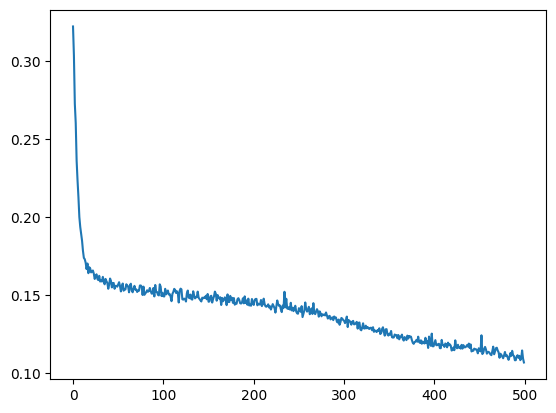

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [33]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep4/up_change500.pth')

In [39]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    A = adj_lr.to(DEVICE)
    for layer in super_resolver:
        A = layer(A)
    test_predictions.append(A)

    
    # pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:00<00:00, 94.08it/s]


In [35]:
torch.save(test_predictions, 'submission_files/tim_deep4/tim_deep4_pred500.pt')

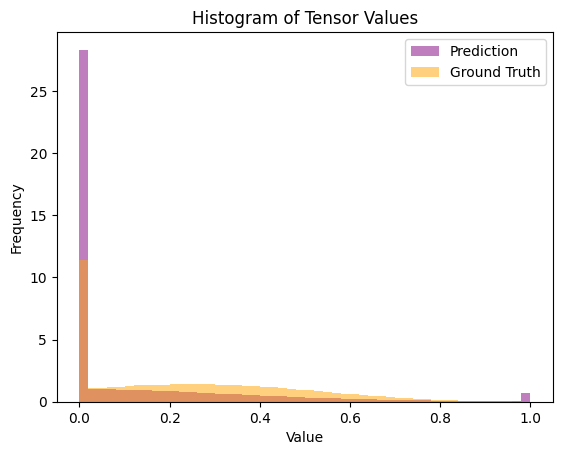

In [41]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.detach().cpu(), hr_train)

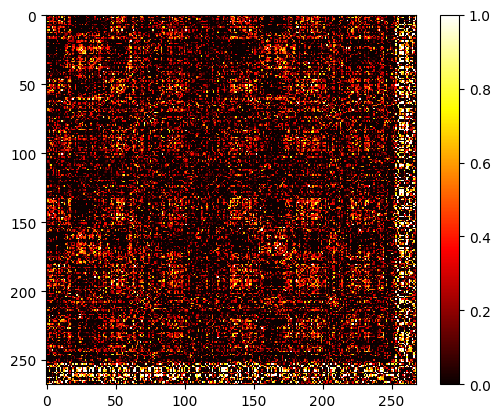

In [43]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].detach().cpu())

In [37]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep4/tim_deep4_pred500.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
